In [4]:
import pandas as pd

In [309]:
df_cdk2_labels = pd.read_json(r"./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")
df_cdk2_labels.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a


### Datos CDK2 de CSAR

In [78]:
csar_data = pd.read_excel('../ARCHIVOS/CDK2_Binding_Data_Corrected_2016AUG18.xlsx', sheet_name="Binding", index_col=0)
csar_data[["PDB ID", "Experimental Result, Average Value", "ActiveInactive"]].head(10)
# Limpiamos los datos y asignamos el valor de activo
csar_data["ActiveInactive"].fillna("Active", inplace=True)
# para el caso del ligando CS12, que es activo pero no posee valor de pKi
csar_data.at["CS12", "Experimental Result, Average Value"] = 99999
# Se ordena el índice
reindex = csar_data.index.to_series().str.rsplit('S').str[-1].astype(int).sort_values()
# Se reasigna el indice
csar_data = csar_data.reindex(index= reindex.index)

In [79]:
csar_data.head(5)

,Data Source,Target,SMILES,Chemical Series,"Experimental Result, Average Value Operator","Experimental Result, Average Value","Experimental Result, SEM","Experimental Result, Type","Experimental Result, Unit","Experimental Result, Protocol","Experimental Result, comment",PDB ID,LIGAND ID,ActiveInactive
Compound_ID,,,,,,,,,,,,,,
CS1,UnivMichigan,CDK2 Kinase,Brc1ccc(cc1)C(=O)Nc1n[nH]c(c1)C CS1,1.0,NaN,33200,7040.0,Kd,nM,OctetRed_Method1,NaN,4EK4,NaN,Active
CS2,UnivMichigan,CDK2 Kinase,O=C(Nc1n[nH]c(c1)C1CC1)CCC CS2,1.0,NaN,1840,368.0,Kd,nM,OctetRed_Method1,NaN,NaN,NaN,Active
CS3,UnivMichigan,CDK2 Kinase,O=C(Nc1n[nH]c(c1)C1CC1)c1ccc(cc1)C(=O)N CS3,1.0,NaN,808,114.0,Kd,nM,OctetRed_Method1,NaN,4EK5,NaN,Active
CS4,UnivMichigan,CDK2 Kinase,O=C(Nc1n[nH]c(c1)C1CC1)c1ccc(cc1)C(=O)[O-] CS4,1.0,NaN,21200,4570.0,Kd,nM,OctetRed_Method1,NaN,4FKG,NaN,Active
CS5,UnivMichigan,CDK2 Kinase,Brc1ccc(cc1)C(=O)Nc1n[nH]c(c1)C1CCCCC1 CS5,1.0,>,100000,NaN,Kd,nM,OctetRed_Method1,NaN,NaN,NaN,Inactive


### Directorio de resultados

In [80]:
import glob
dir_dockings = "../ARCHIVOS/CRISTALES/DOCKINGS/DOCK_402_PROT_111_LIGS/"

### Vina y Vinardo

In [96]:
dir_vina_res = dir_dockings + 'VINA/CSV/'
dir_vina_16_res = dir_dockings + 'VINA/CSV_16/'
df_vina_results = pd.DataFrame(csar_data["ActiveInactive"]) # Creamos el dataframe que se irá llenando
df_vina_results.index.names = ["Ligando"] # Renombramos el índice

dir_vinardo_res = dir_dockings + 'VINARDO/CSV/'
dir_vinardo_16_res = dir_dockings + 'VINARDO/CSV_16/'
df_vinardo_results = pd.DataFrame(csar_data["ActiveInactive"]) # Creamos el dataframe que se irá llenando
df_vinardo_results.index.names = ["Ligando"] # Renombramos el índice

def get_docking_results(df_final, dir_1, dir_2):
    # Iteramos para ir llenando el dataframe
    for pdb_id in df_cdk2_labels.index:
        # Leemos los datasets
        """ Como tenemos dos directorios de resultados, debido a que se hizo el docking en dos partes, cargamos cada resultado. """
        file_a = glob.glob(dir_1 + pdb_id + "*")
        file_b = glob.glob(dir_2 + pdb_id + "*")

        a = pd.read_csv(file_a[0])
        b = pd.read_csv(file_b[0])
        # Concatena los resultados
        c = pd.concat([a, b], ignore_index=True)
        # Establece un indice
        c.set_index("Ligando", inplace=True)
        # Se ordena el índice
        i = c.index.to_series().str.rsplit('S').str[-1].astype(int).sort_values()
        # Se reasigna el indice
        c = c.reindex(index= i.index)
        # Se renombra la columna
        colname = c.columns[0].rsplit("_")[1]
        c.columns = [ colname ]
        # Se añade al dataframe principal
        df_final[ colname ] = c[ colname ]

get_docking_results(df_vina_results, dir_vina_res, dir_vina_16_res)

get_docking_results(df_vinardo_results, dir_vinardo_res, dir_vinardo_16_res)

# Vina

In [129]:
import matplotlib
import matplotlib.pyplot as plt

activos =  df_vina_results.ActiveInactive == "Active"

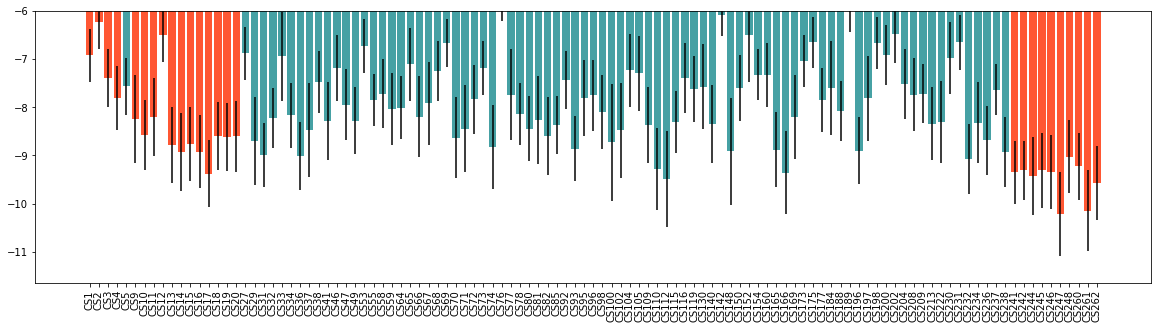

In [295]:
sc_promedio_vrd = df_vinardo_results.mean(axis=1)
error_vrd = df_vinardo_results.std(axis=1)

fig = plt.figure(figsize=(20, 5))
plt.bar( df_vinardo_results.index, sc_promedio_vrd , yerr = error_vrd, color="#46A1A4" )
plt.bar( df_vinardo_results[ activos ].index, sc_promedio_vrd[ activos ], color="#FF5733" )
plt.xticks(rotation=90); plt.ylim(top=-6); 
plt.show()


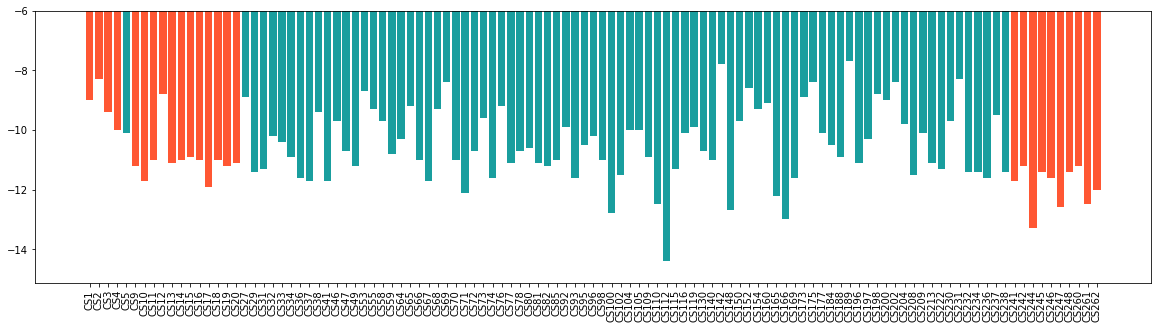

In [213]:
sc_minimo_vrd = df_vinardo_results.min(axis=1)

fig = plt.figure(figsize=(20, 5))
plt.bar( df_vinardo_results.index, sc_minimo_vrd, color="#199E9E" )
plt.bar( df_vinardo_results[ activos ].index, sc_minimo_vrd[ activos ], color="#FF5733" )
plt.xticks(rotation=90); plt.ylim(top=-6)
plt.show()

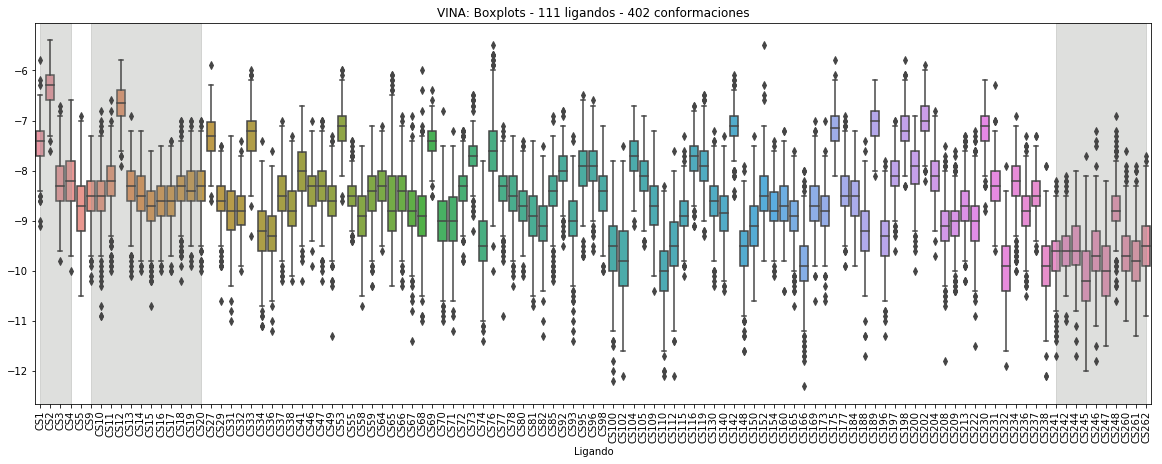

In [283]:
num_ligs, num_conf = df_vina_results[ df_cdk2_labels.index ].shape

fig, ax = plt.subplots(figsize =(20, 7))
ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
sns.boxplot(ax = ax,  data = df_vina_results[ df_cdk2_labels.index ].T )
plt.title(F"VINA: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones")
plt.xticks(rotation=90)
plt.show()

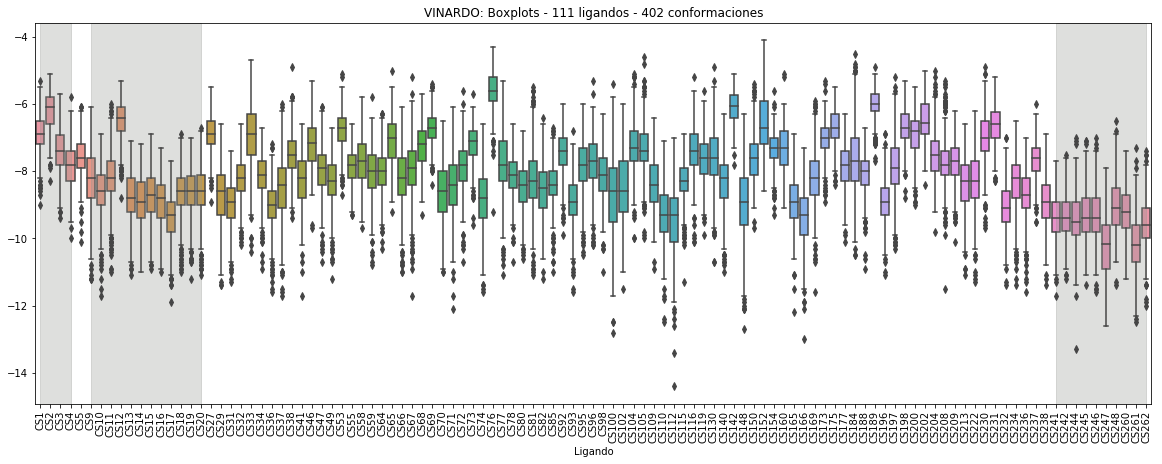

In [286]:
import seaborn as sns
num_ligs, num_conf = df_vinardo_results[ df_cdk2_labels.index ].shape

fig, ax = plt.subplots(figsize =(20, 7))
ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
sns.boxplot(ax = ax,  data = df_vinardo_results[ df_cdk2_labels.index ].T )
plt.title(F"VINARDO: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones")
plt.xticks(rotation=90)
plt.show()

## ROC - Curvas ROC


In [233]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [279]:
true_values = [ 1 if i == "Active" else 0 for i in csar_data["ActiveInactive"]]
# Scorings de Vina y Vinardo
sc_promedio_vrd = df_vinardo_results.mean(axis=1)
sc_promedio_vina = df_vina_results.mean(axis=1)

print("Vina (scoring promedio):", roc_auc_score(np.array(true_values),  np.array(- sc_promedio_vina )) )
print("Vinardo (scoring promedio):", roc_auc_score(np.array(true_values),  np.array(- sc_promedio_vrd )) )

Vina (scoring promedio): 0.5524886877828055
Vinardo (scoring promedio): 0.7610859728506787


In [281]:
sc_min_vrd = df_vinardo_results.min(axis=1)
sc_min_vina = df_vina_results.min(axis=1)

print("Vina (scoring minimo):", roc_auc_score(np.array(true_values),  np.array(- sc_min_vina )) )
print("Vinardo (scoring minimo):", roc_auc_score(np.array(true_values),  np.array(- sc_min_vrd )) )

Vina (scoring minimo): 0.5366515837104072
Vinardo (scoring minimo): 0.652262443438914


In [326]:
# Calcular la curva roc de cada conformacion
# Vina
df_cdk2_labels["ROC_vrd"] = 0.0
df_cdk2_labels["ROC_vina"] = 0.0
for pdb in df_cdk2_labels.index:
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "ROC_vrd"] = roc_vrd
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "ROC_vina"] = roc_vina

In [335]:
df_cdk2_labels.ROC_vrd.min()

0.4972850678733032

Text(0.5, 1.0, 'Vinardo')

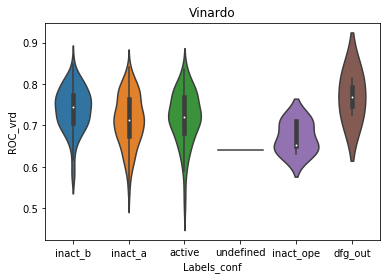

In [359]:
fig, axes = plt.subplots()

sns.violinplot(x="Labels_conf", y="ROC_vrd", data= df_cdk2_labels, ax = axes)
axes.set_title('Vinardo')

Text(0.5, 1.0, 'Vinardo')

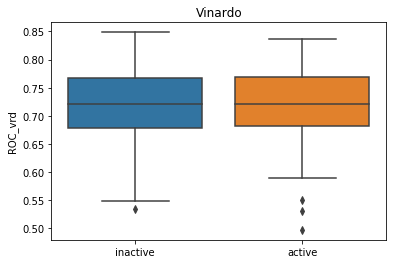

In [371]:
fig, axes = plt.subplots()

active_inactive_labels = [ "active" if i == "active" else "inactive" for i in df_cdk2_labels.Labels_conf]
sns.boxplot(x=active_inactive_labels, y=df_cdk2_labels["ROC_vrd"], ax = axes)
axes.set_title('Vinardo')

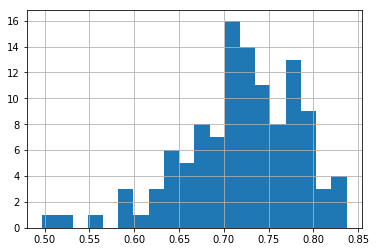

In [351]:
# Roc de las activas
( df_cdk2_labels.ROC_vrd[ df_cdk2_labels.Labels_conf == "active" ] ).hist( bins = 20)

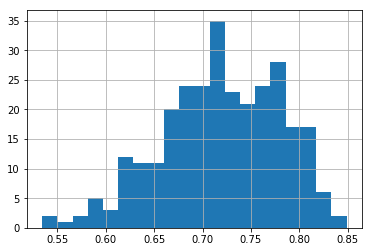

In [356]:
# Roc de las activas
( df_cdk2_labels.ROC_vrd[ df_cdk2_labels.Labels_conf != "active" ] ).hist( bins=20 )